In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use("seaborn-colorblind")

prop_cycle = plt.rcParams['axes.prop_cycle']
colours = prop_cycle.by_key()['color']
colours


['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']

In [2]:
codes = [
    "infectious",
    "neoplasms",
    "blood",
    "endocrine",
    "mental",
    "nervous",
    "eye",
    "ear",
    "circulatory",
    "respiratory",
    "digestive",
    "skin",
    "muscoloskeletal",
    "genitourinary",
    "perinatal",
    "congenital",
    "abnormal_findings",
    "injury",
    "external_causes", 
    "contact_factors",
    "special_use",
]

conditions = [
    "ami",
    "cva",
    "chf",
    "ctd",
    "dementia",
    "diabetes",
    "liver_disease",
    "peptic_ulcer",
    "pvd",
    "pulmonary_disease",
    "cancer",
    "diabetic_complications",
    "paraplegia",
    "renal_disease",
    "metastatic_cancer",
    "sever_liver_disease",
    "hiv",
    "cdiff",
    "mrsa",
    "obese",
    "sepsis",
]

In [3]:
knee_results = pd.read_csv("../data/clusters/knee_results.csv", header=None).set_index(0)
with open("../data/clusters/n_clusters.txt", "r") as f:
    n_clusters = int(f.read())

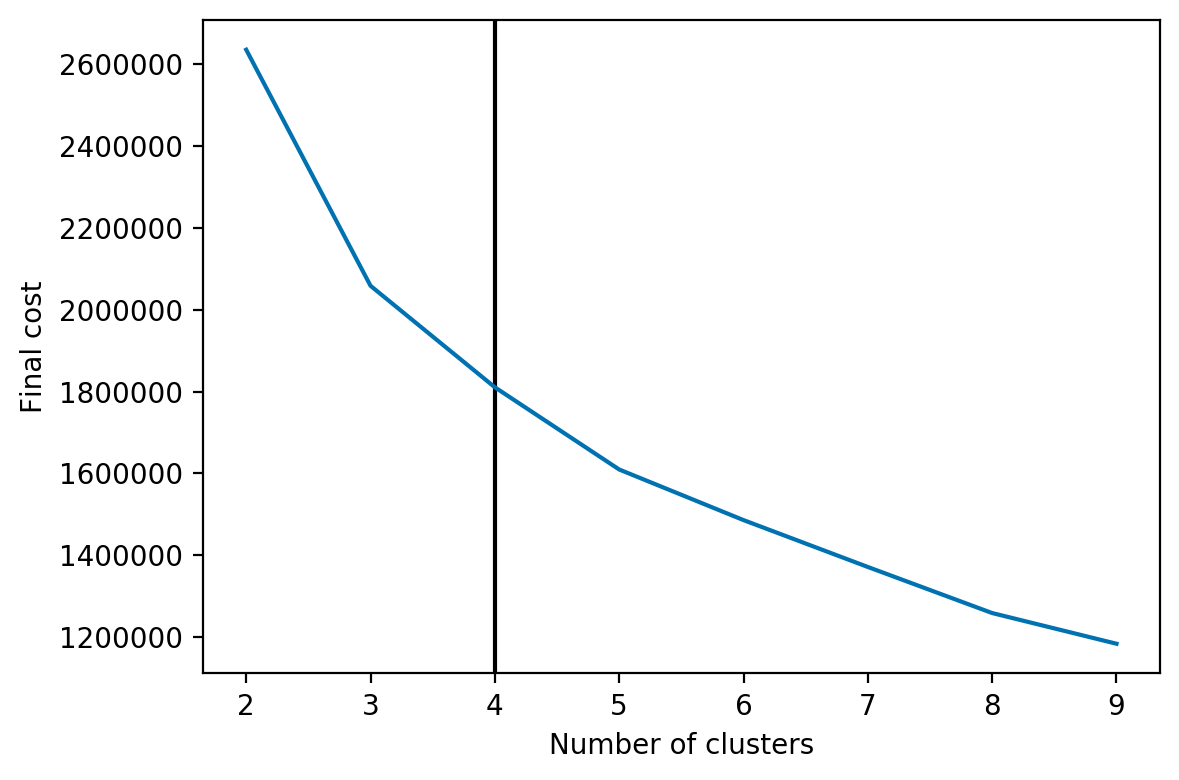

In [4]:
fig, ax = plt.subplots(dpi=200)

ax.plot(knee_results.index, knee_results.values)

ylims = ax.get_ylim()
ax.vlines(n_clusters, *ylims)

ax.set(
    xlabel="Number of clusters",
    ylabel="Final cost",
    ylim=ylims,
)

plt.tight_layout()
plt.savefig("../img/knee_results.pdf", transparent=True)

In [5]:
copd = pd.read_csv(
    "../data/clusters/copd_clustered.csv",
    parse_dates=["admission_date", "discharge_date"]
).dropna(subset=["cluster"]).drop_duplicates("spell_id")

copd["cluster"] = copd["cluster"].astype(int)

In [6]:
copd["cluster"].value_counts().sort_index(), len(copd)

(0    1076
 1    2093
 2    7536
 3     156
 Name: cluster, dtype: int64,
 10861)

In [7]:
los_xlims, los_ylims = (-10, 149), (-0.01, 0.199)

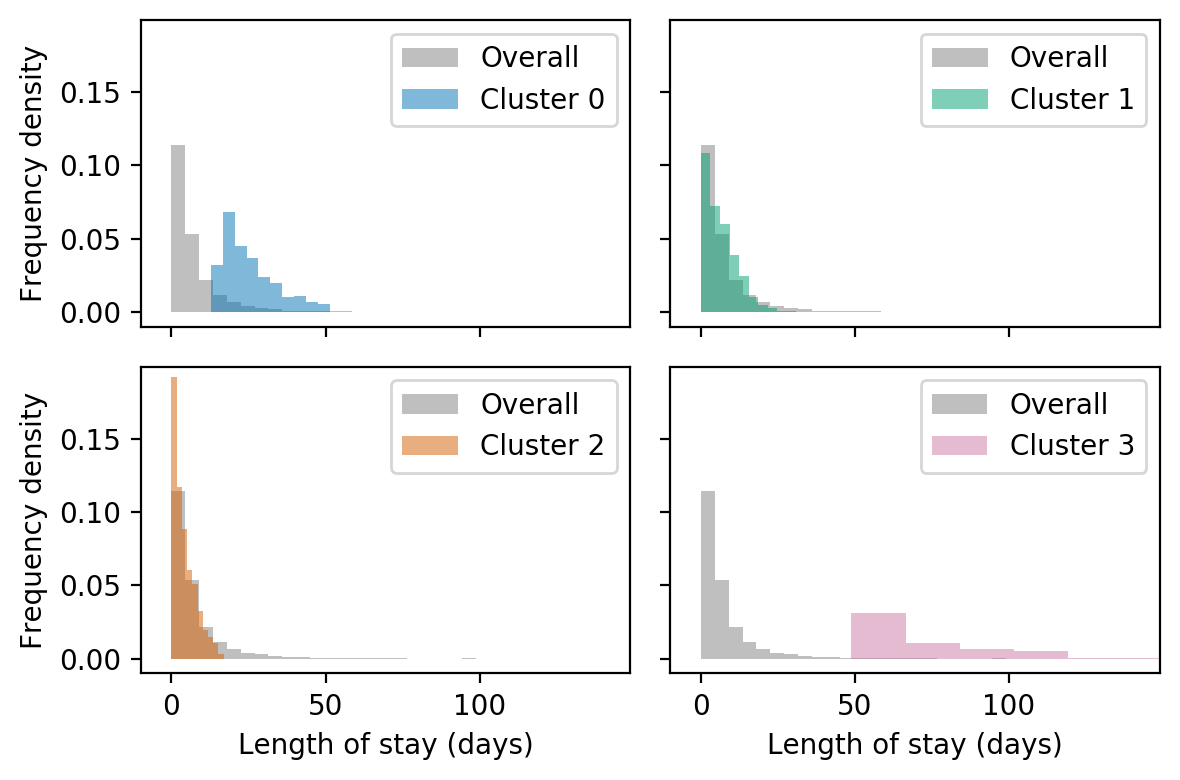

In [8]:
fig, axes = plt.subplots(ncols=2, nrows=2, dpi=200, sharex=True, sharey=True)
axes = axes.reshape(4)

for pos, (ax, (cluster, times)) in enumerate(zip(axes, copd.groupby("cluster")["true_los"])):

    ax.hist(copd["true_los"], bins=50, color="gray", density=True, alpha=0.5, label="Overall")

    ax.hist(
        times,
        density=True,
        bins=10,
        color=colours[cluster],
        alpha=0.5,
        label=f"Cluster {cluster}",
    )

    ax.set_xlim(los_xlims)
    ax.set_ylim(los_ylims)
    if pos > 1:
        ax.set_xlabel("Length of stay (days)")
    if pos % 2 == 0:
        ax.set_ylabel("Frequency density")

    ax.legend()
    plt.tight_layout()

plt.tight_layout()
plt.savefig("../img/cluster_los.pdf", transparent=True)

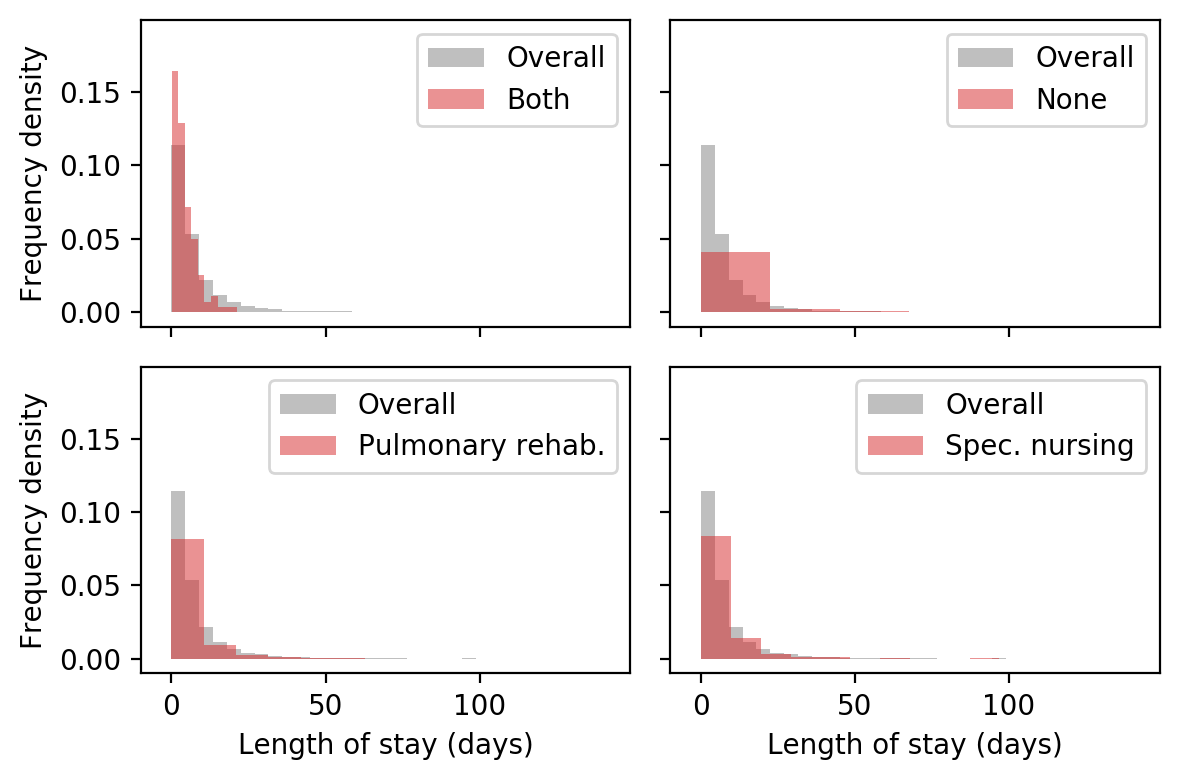

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=2, dpi=200, sharex=True, sharey=True)
axes = axes.reshape(4)

intervention_labels = {"none": "None", "both": "Both", "pr": "Pulmonary rehab.", "sn": "Spec. nursing"}

xs = np.linspace(0, 100, 300)

for pos, (ax, intervention) in enumerate(zip(axes, ["both", "none", "pr", "sn"])):

    times = copd[copd["intervention"] == intervention]["true_los"]

    ax.hist(copd["true_los"], bins=50, color="gray", density=True, alpha=0.5, label="Overall")

    ax.hist(
        times,
        density=True,
        bins=10,
        color="tab:red",
        alpha=0.5,
        label=intervention_labels[intervention],
    )

    ax.set_xlim(los_xlims)
    ax.set_ylim(los_ylims)
    if pos > 1:
        ax.set_xlabel("Length of stay (days)")
    if pos % 2 == 0:
        ax.set_ylabel("Frequency density")

    ax.legend()
    plt.tight_layout()

plt.tight_layout()
plt.savefig("../img/intervention_los.pdf", transparent=True)

In [10]:
def histograms(data, column, group="cluster", density=True, colours=colours, bins=10):

    fig, axes = plt.subplots(ncols=2, nrows=2, dpi=200, sharex=True, sharey=True)
    axes = axes.reshape(4)

    column_labels = {
        "wimd": "Welsh Index of Multiple Deprivation",
        "charlson_gross": "Charlson Comorbidity Index",
        "n_copd_admissions_last_year": "COPD admissions in last year",
        "n_icds": "No. of ICDs",
        "age": "Age (years)",
        "spell_cost": "Cost of spell (£1000s)",
        "n_episodes": "No. of episodes",
    }
    
    str_ints = (x for x in range(10))
    for (label, values), ax in zip(copd.groupby(group)[column], axes):

        factor = 1000 if column == "spell_cost" else 1
        ax.hist(
            copd[column] / factor,
            bins=bins,
            facecolor="gray",
            alpha=0.2,
            density=True,
            label="Overall",
        )

        label_name = intervention_labels.get(label, f"Cluster {label}")
        if isinstance(label, str):
            label = next(str_ints)
            colour = "tab:red"
        else:
            colour = colours[label]

        ax.hist(
            values / factor, bins=bins, alpha=0.5, facecolor=colour, density=True, label=label_name
        )

        if label > 1:
            ax.set_xlabel(column_labels[column])
        if label % 2 == 0:
            ax.set_ylabel("Frequency density")

        ax.legend()

    plt.tight_layout()
    plt.savefig(f"../img/{group}_{column}.pdf", transparent=True)

/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in l

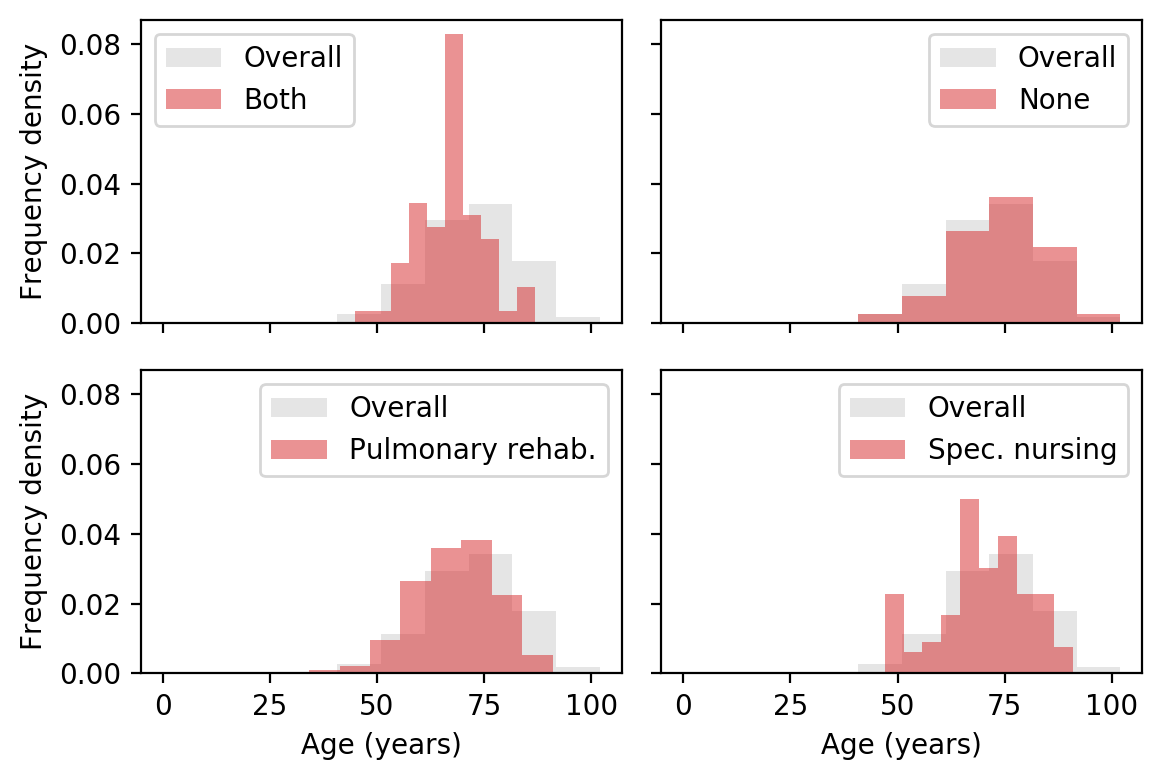

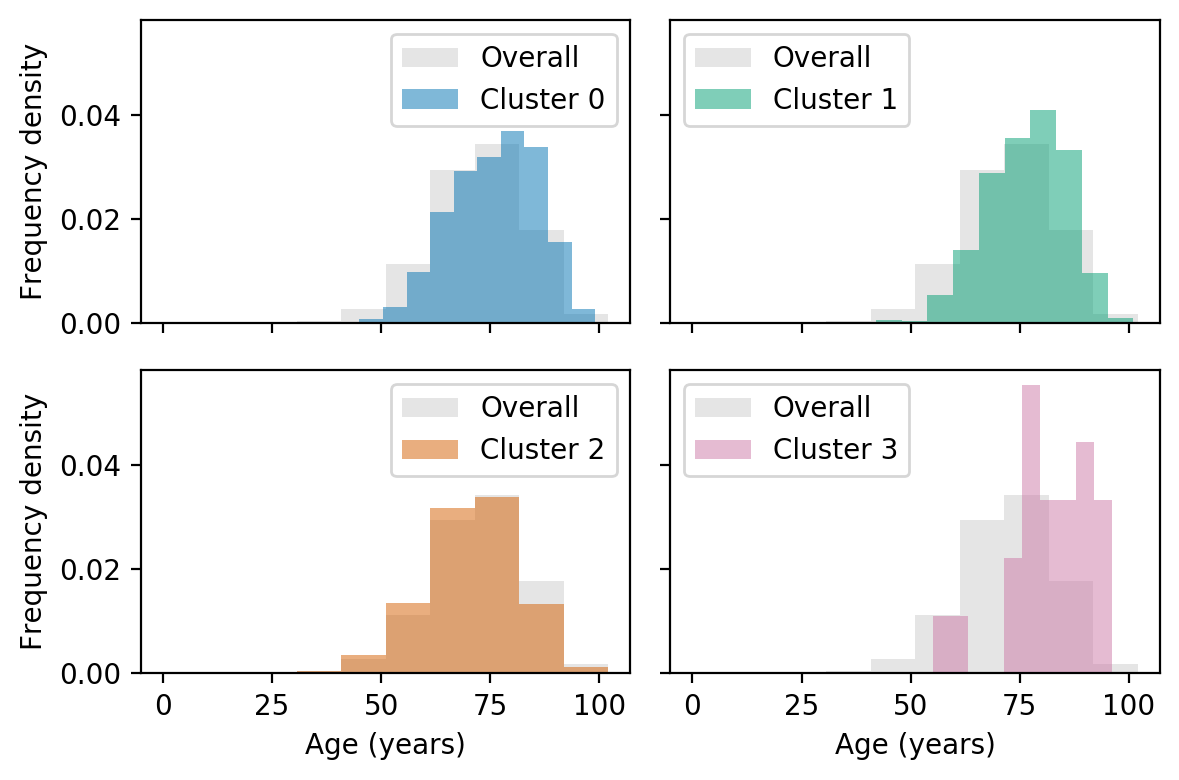

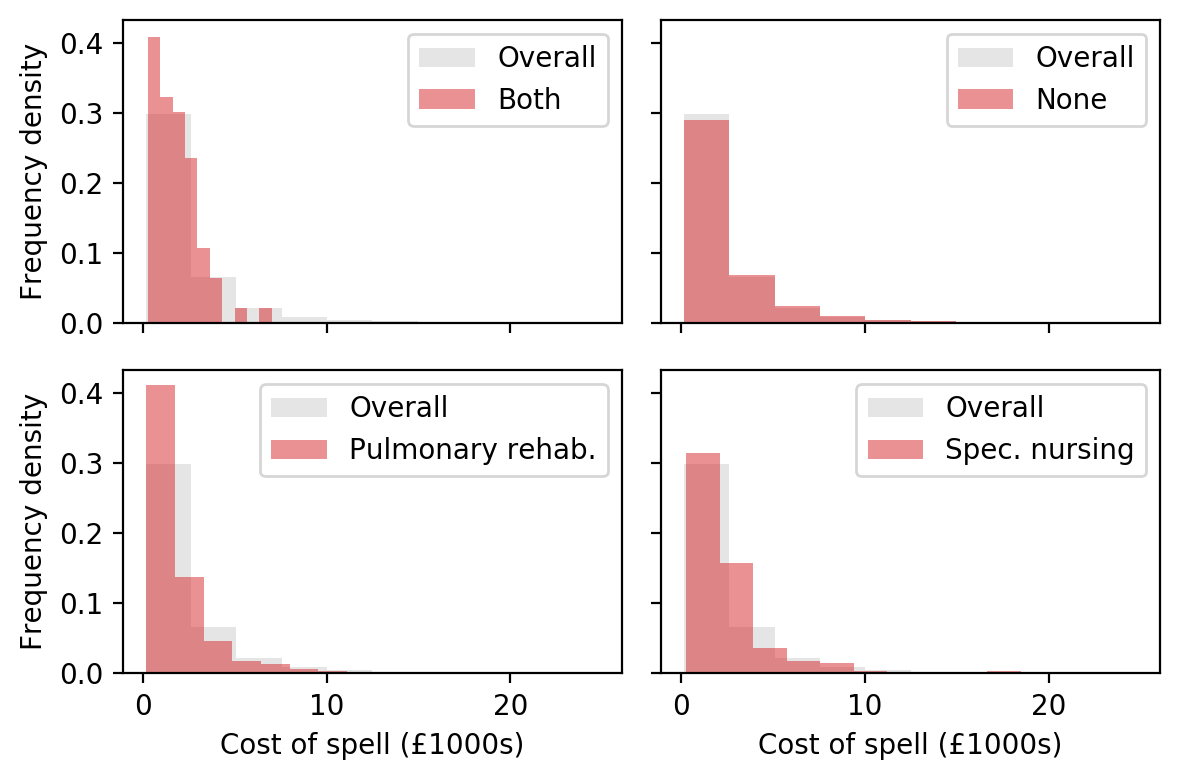

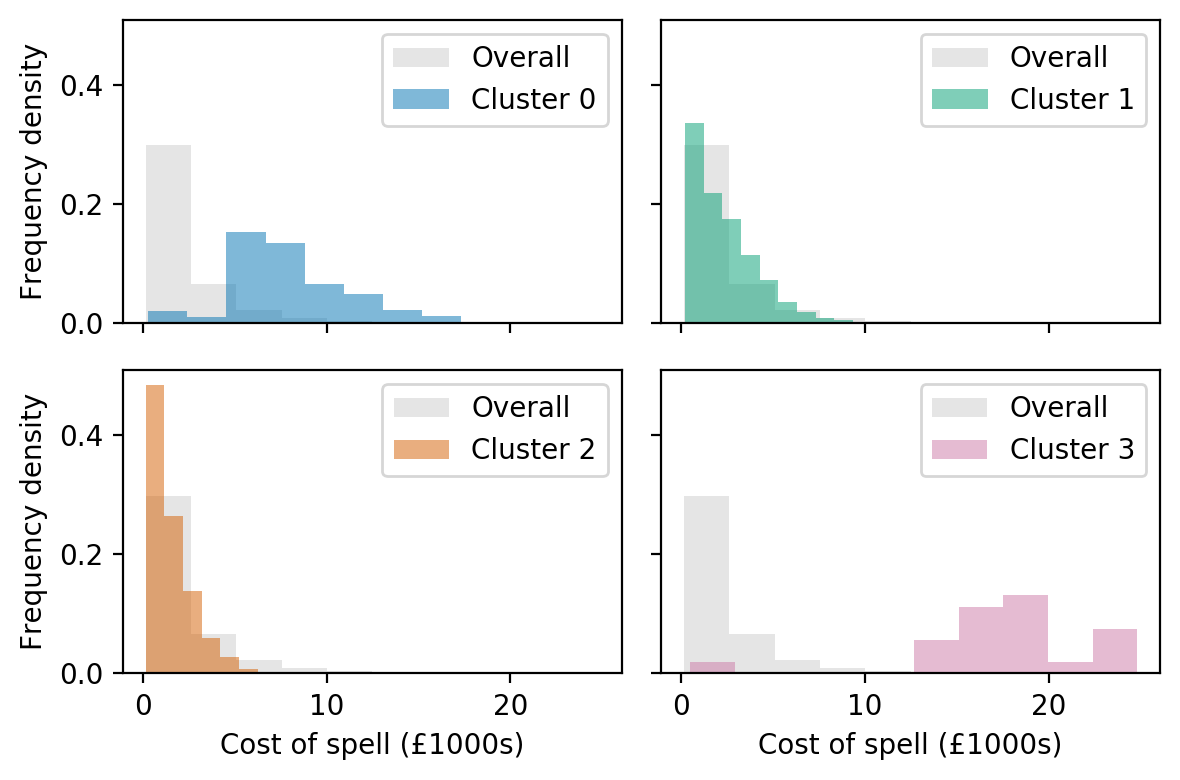

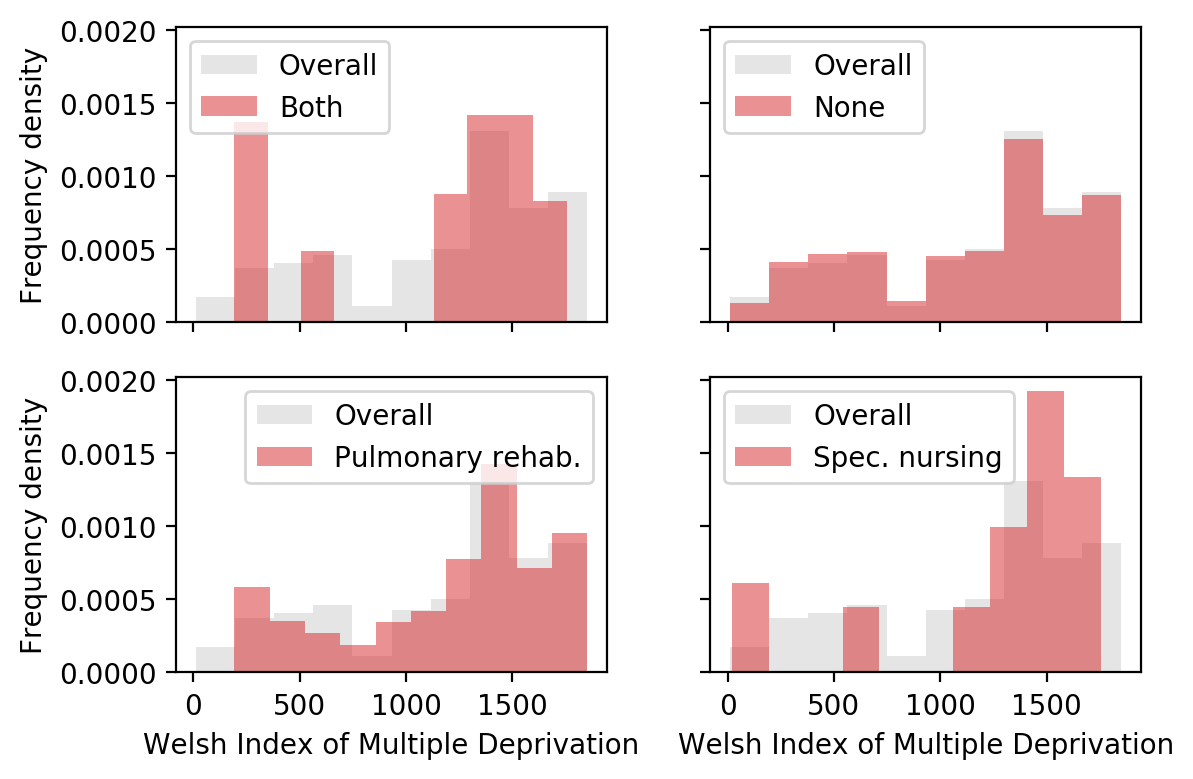

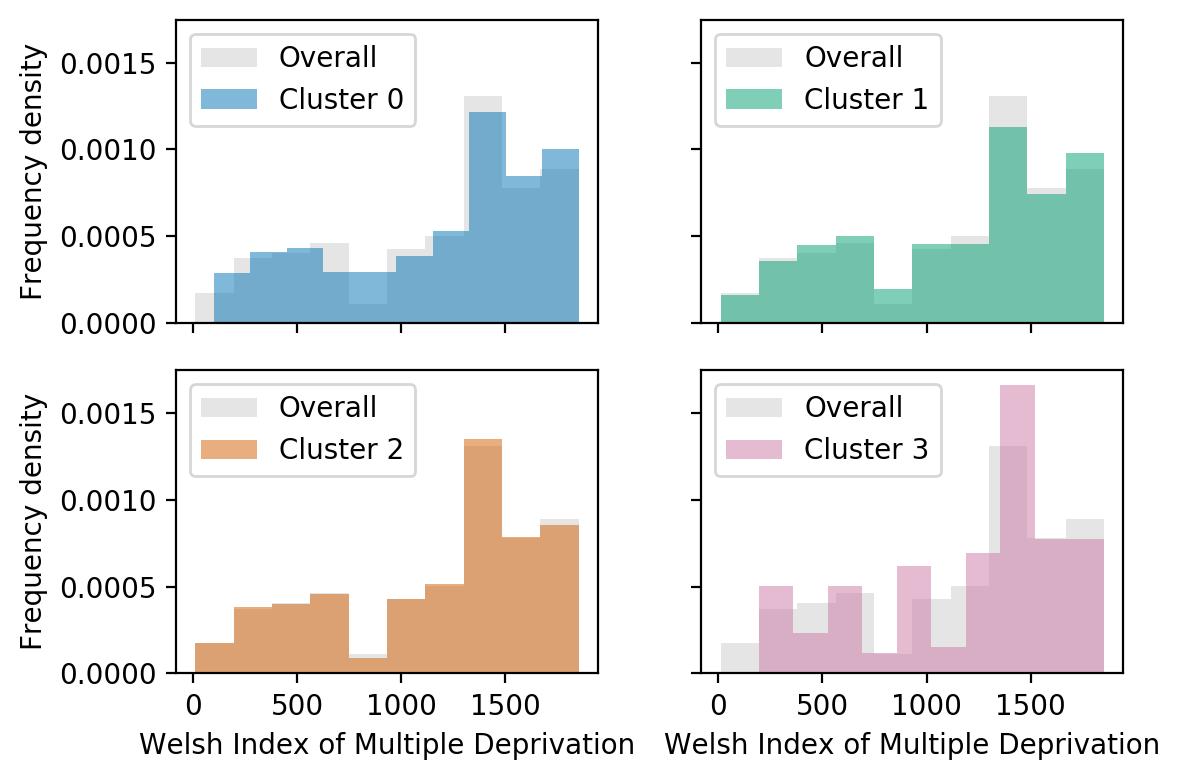

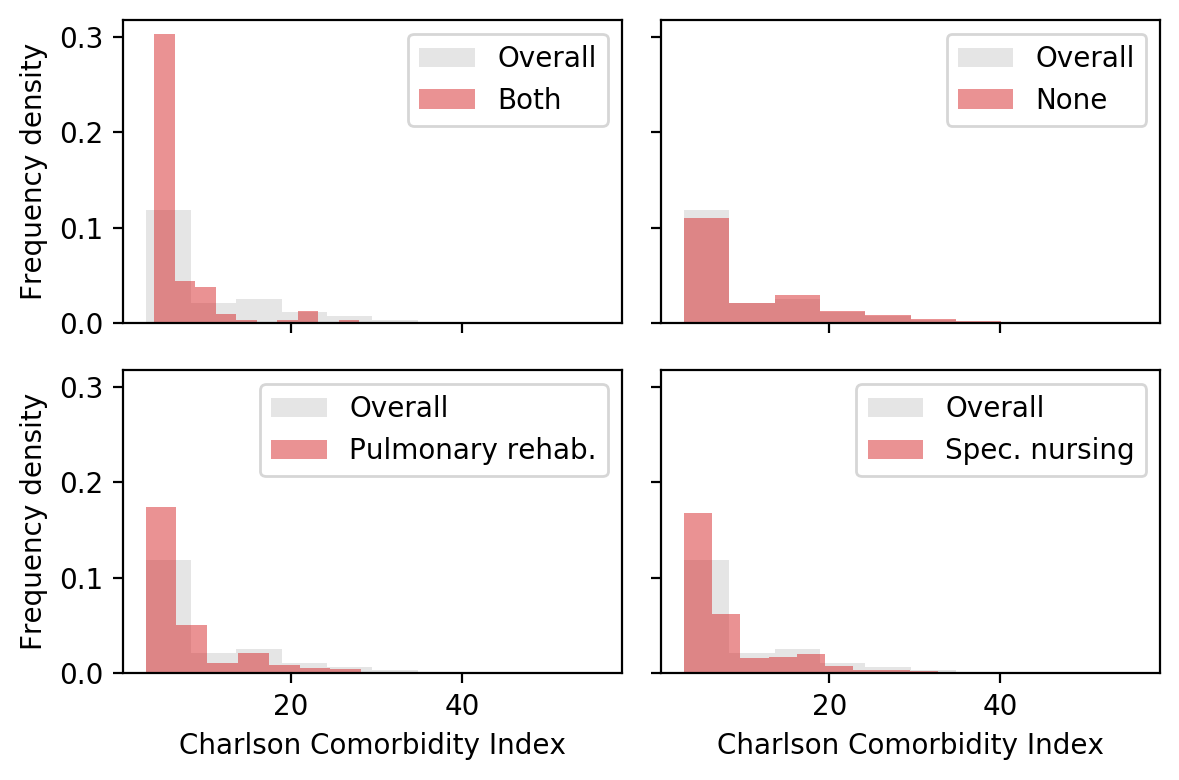

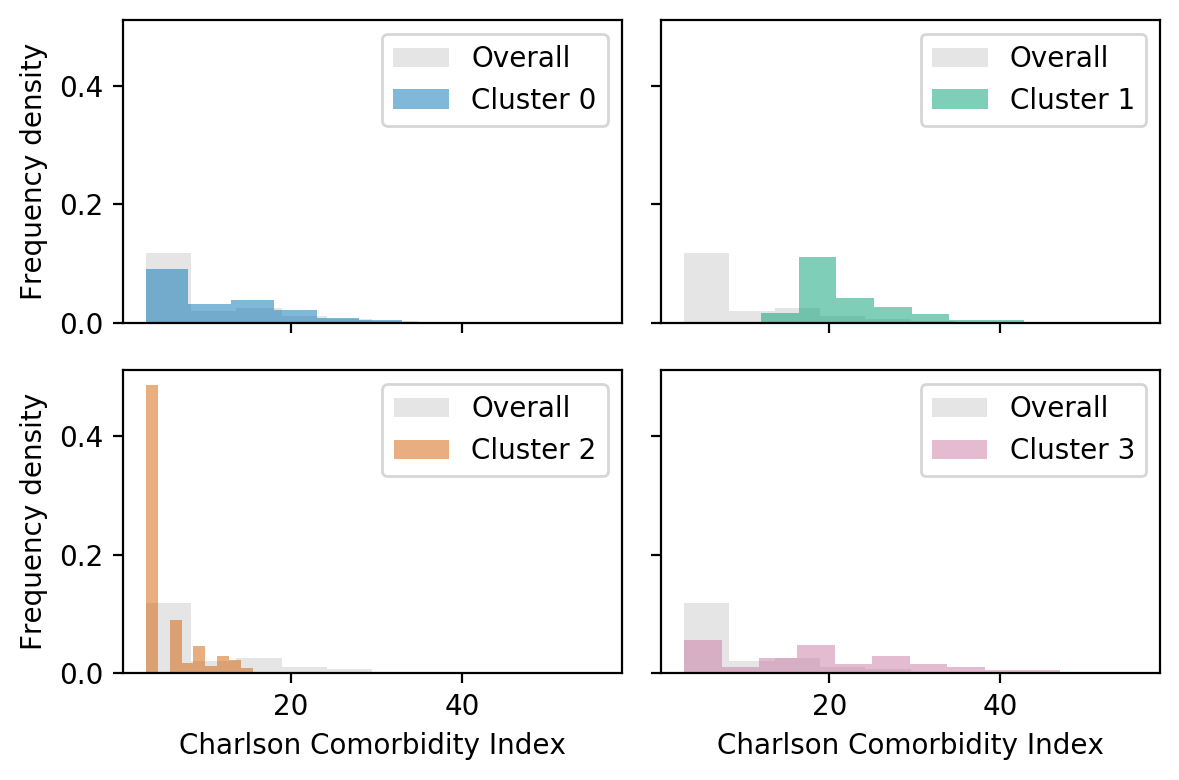

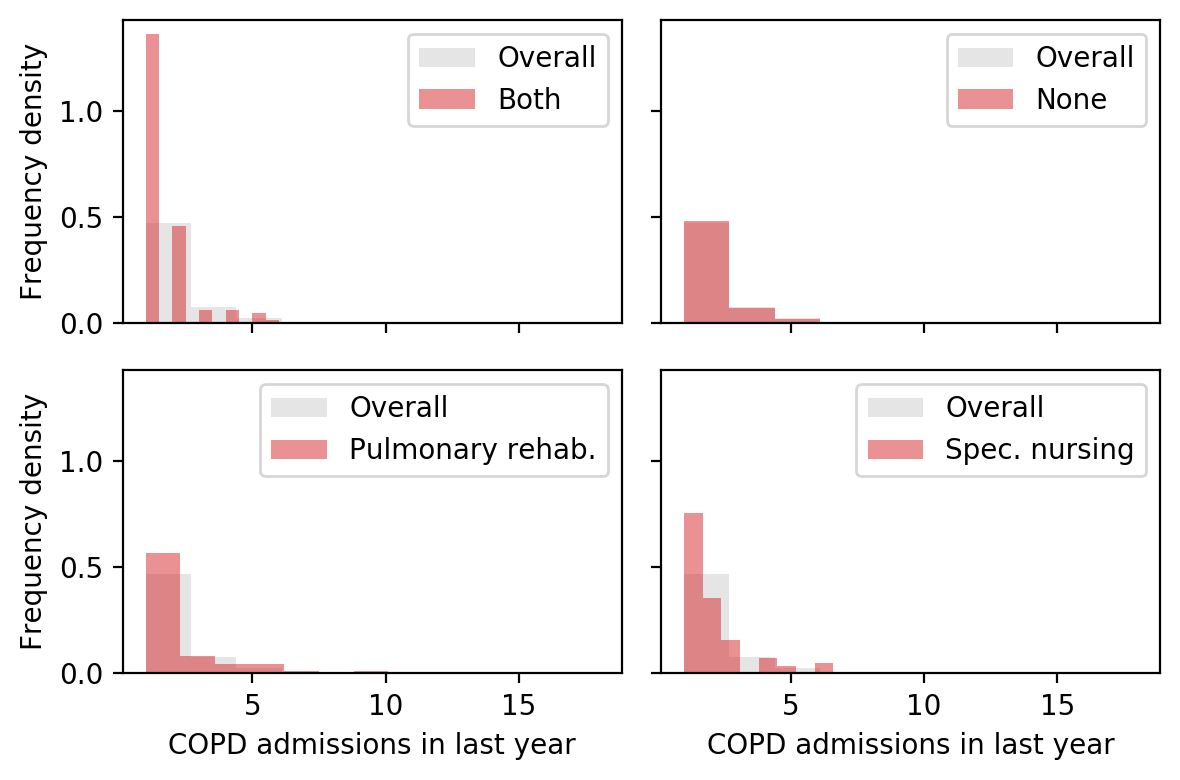

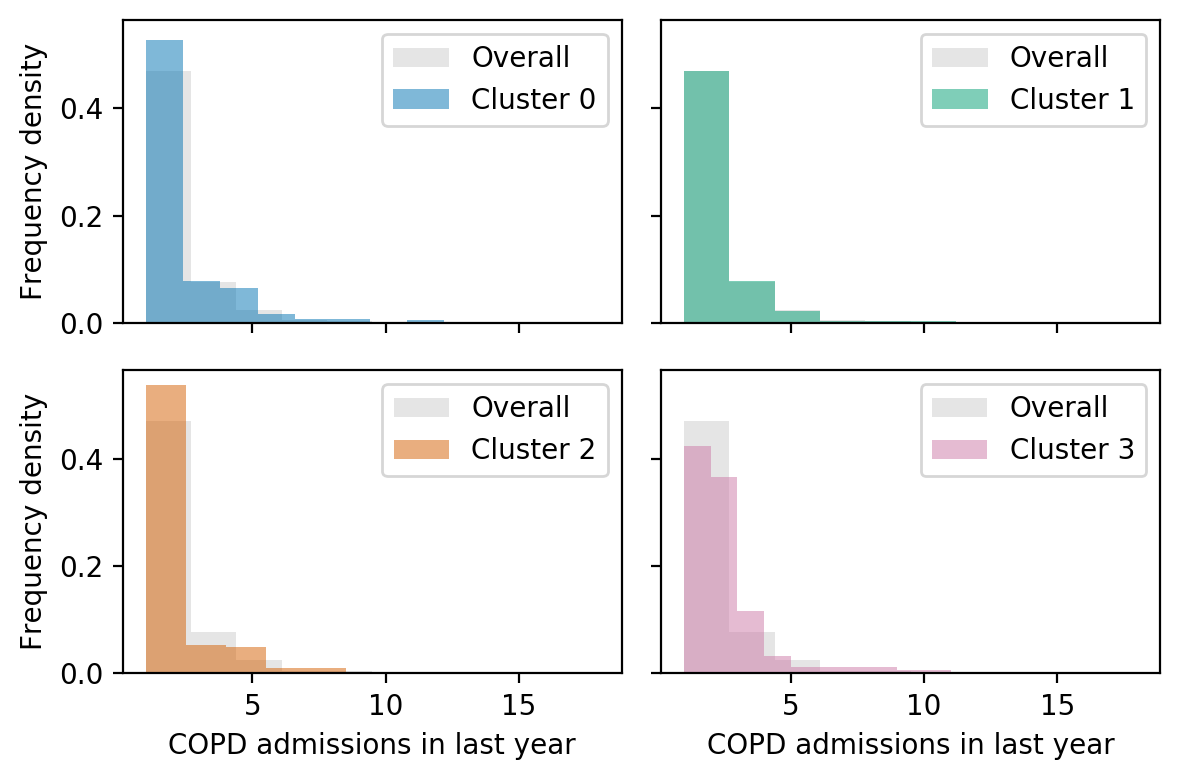

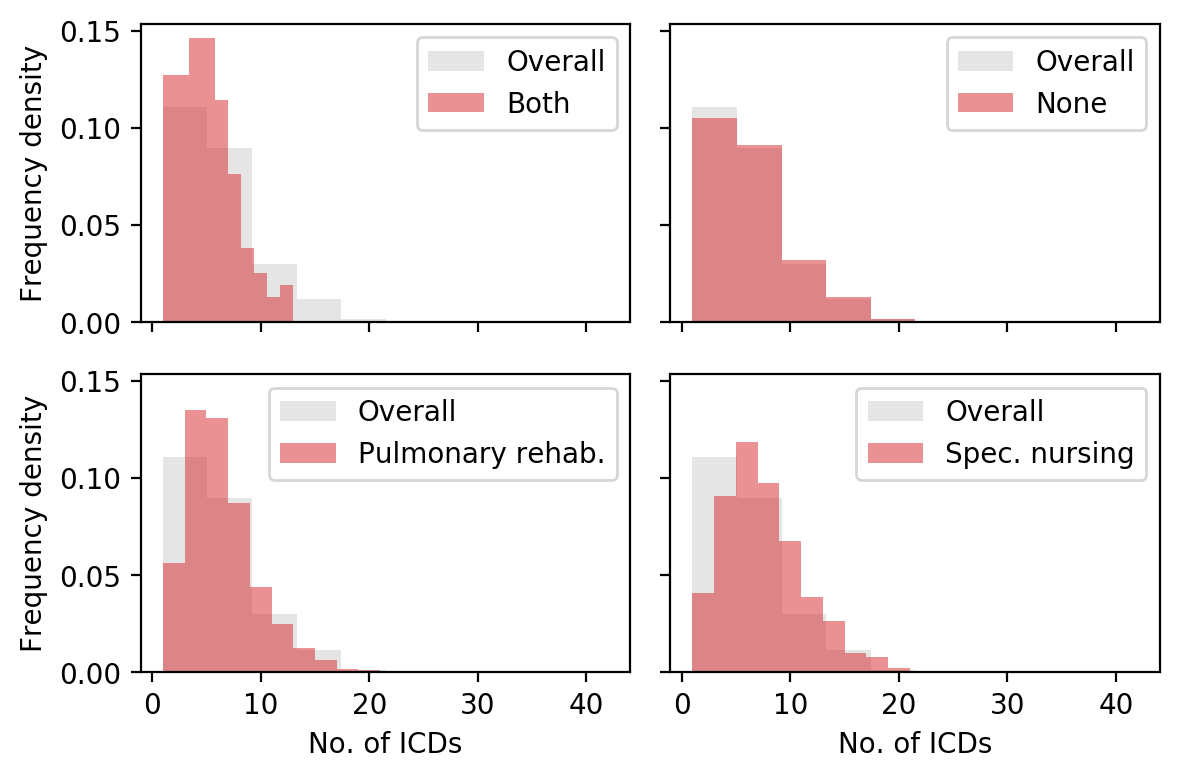

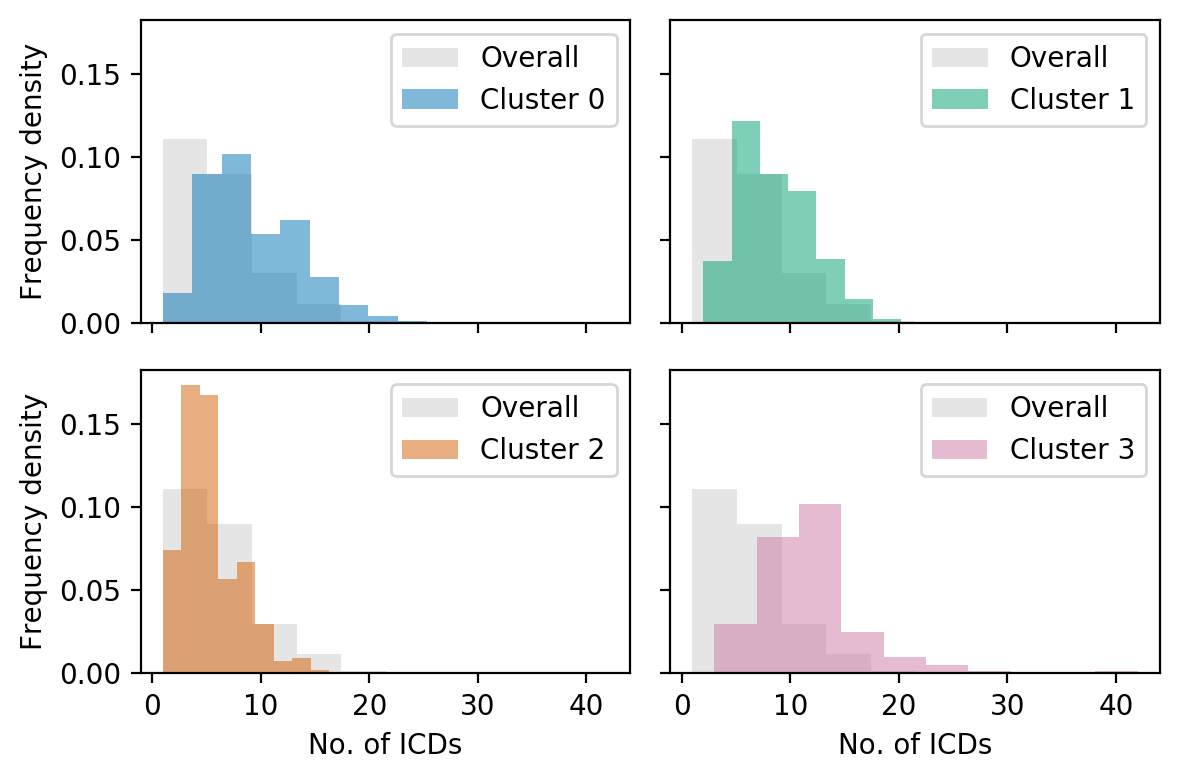

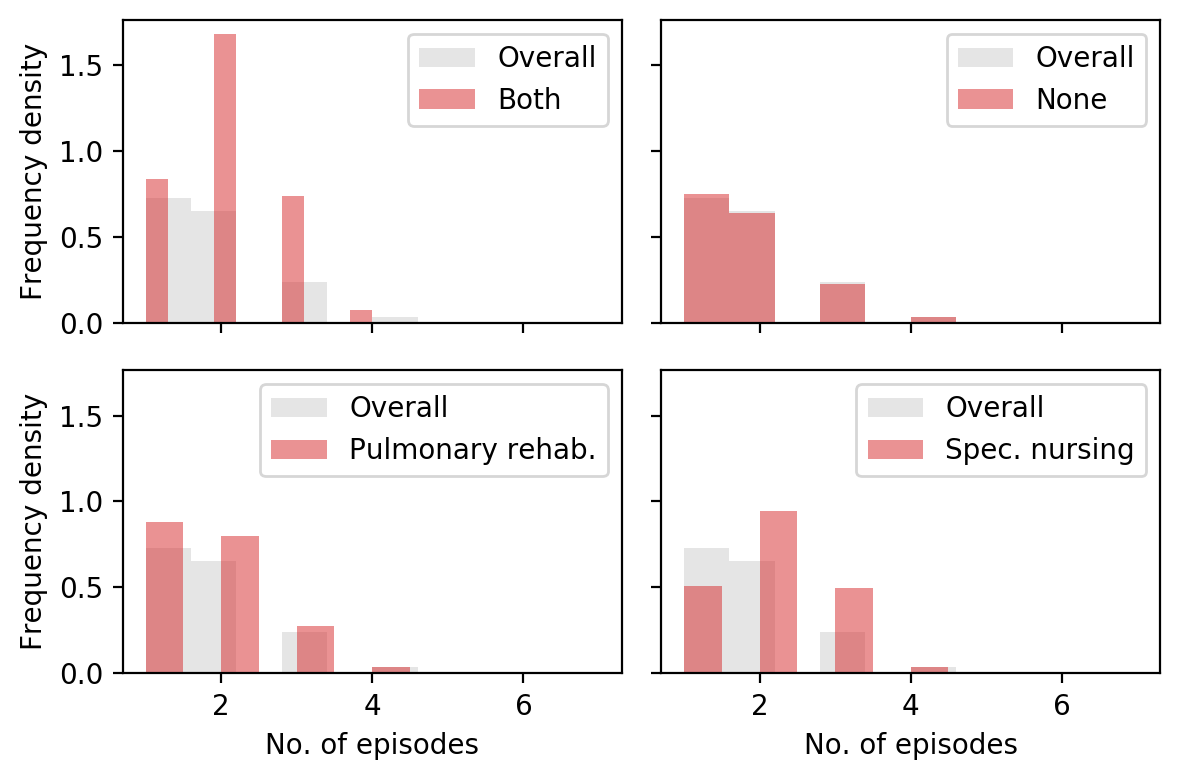

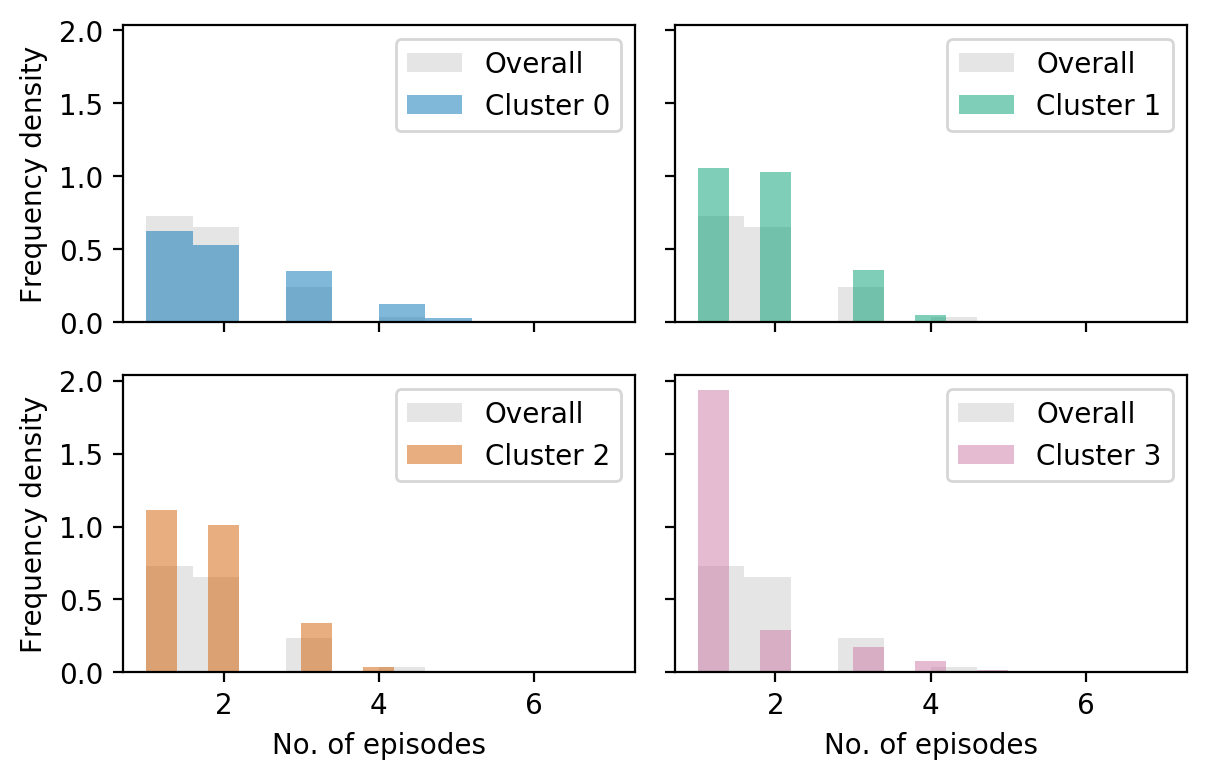

In [11]:
for col in [
    "age",
    "spell_cost",
    "wimd",
    "charlson_gross",
    "n_copd_admissions_last_year",
    "n_icds",
    "n_episodes",
]:
    histograms(copd, col, group="intervention")
    histograms(copd, col, group="cluster")

In [12]:
dfs = []
for cluster, values in copd.groupby(
    ["cluster", "patient_id"]
)[conditions].max().astype(bool).sum(axis=1).reset_index().groupby("cluster")[0]:
    proportions = values.value_counts(normalize=True).sort_index()
    dfs.append(pd.DataFrame(data=proportions.values, index=proportions.index, columns=[cluster]))

for intervention, values in copd.groupby(
    ["intervention", "patient_id"]
)[conditions].max().astype(bool).sum(axis=1).reset_index().groupby("intervention")[0]:
    proportions = values.value_counts(normalize=True).sort_index()
    dfs.append(pd.DataFrame(data=proportions.values, index=proportions.index, columns=[intervention]))

ltcs_proportions = pd.concat(dfs, axis=1).fillna(0)

values = copd.groupby("patient_id")[conditions].max().astype(bool).sum(axis=1)
proportions = values.value_counts(normalize=True)

ltcs_proportions["Population"] = proportions
ltcs_proportions

,0,1,2,3,both,none,pr,sn,Population
1,0.327059,0.000000,0.608367,0.172185,0.729730,0.399706,0.528785,0.447674,0.426496
2,0.385882,0.305768,0.319052,0.298013,0.175676,0.299413,0.295309,0.337209,0.298796
3,0.212941,0.400278,0.067540,0.264901,0.067568,0.185665,0.105544,0.104651,0.167463
4,0.060000,0.211953,0.005040,0.198675,0.013514,0.082681,0.047974,0.087209,0.076850
5,0.012941,0.059764,0.000000,0.052980,0.013514,0.023483,0.013859,0.011628,0.021411
6,0.001176,0.016678,0.000000,0.013245,0.000000,0.007583,0.006397,0.011628,0.007456
7,0.000000,0.005559,0.000000,0.000000,0.000000,0.001223,0.002132,0.000000,0.001338
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000245,0.000000,0.000000,0.000191


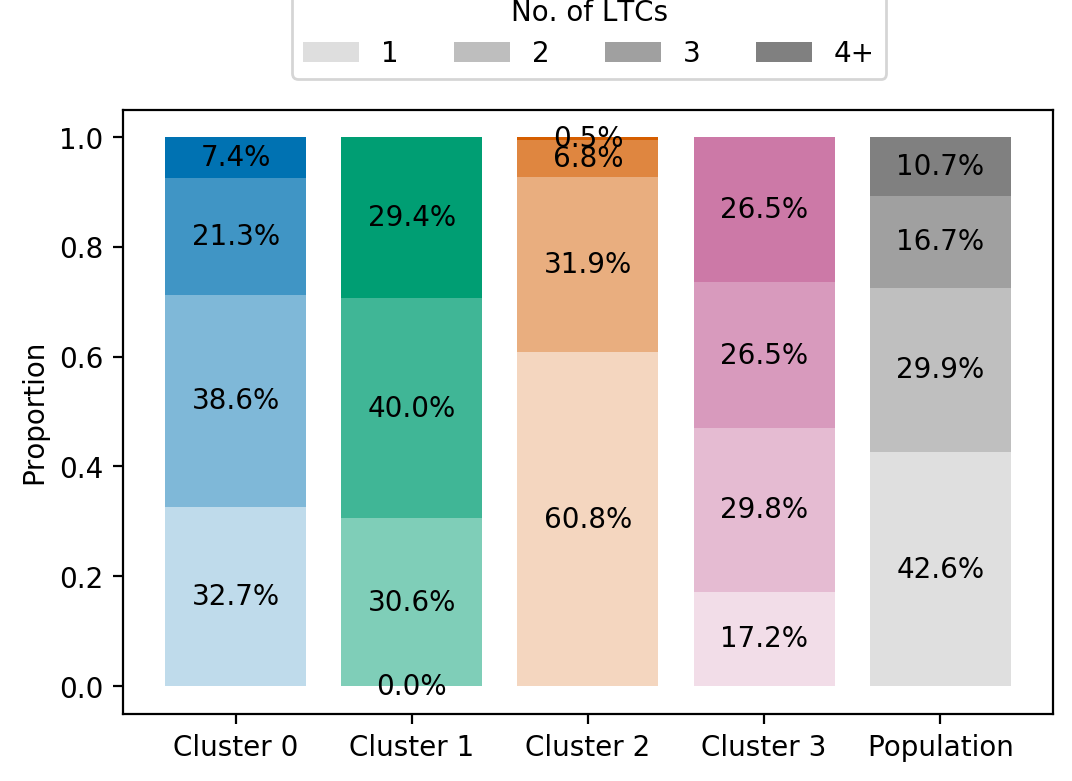

In [13]:
fig, ax = plt.subplots(dpi=200)

handles, labels = [], []
for column in [0, 1, 2, 3, "Population"]:

    bottom = 0
    pos = column
    if isinstance(column, str):
        colour = "gray"
    else:
        colour = colours[column]
        pos = f"Cluster {column}"

    for i in range(1, 5):

        alpha = i / 4
        value = ltcs_proportions.loc[i, column]
        if i == 4:
            value = ltcs_proportions.loc[i:, column].sum()
            i = "4+"

        ax.bar(pos, value, bottom=bottom, fc=colour, alpha=alpha)
        ax.text(pos, bottom + .5 * value, f"{value * 100:.1f}%", color="k", va="center", ha="center")
        bottom += value

        if str(i) not in labels:
            labels.append(str(i))
            handles.append(plt.matplotlib.patches.Patch(fc="gray", alpha=alpha))

ax.set(ylabel="Proportion", ylim=(-0.05, 1.05))

leg = fig.legend(handles, labels, ncol=4, bbox_to_anchor=(0.75, 1.01), title="No. of LTCs")

plt.savefig("../img/cluster_ltcs.pdf", bbox_extra_artists=[leg], transparent=True)

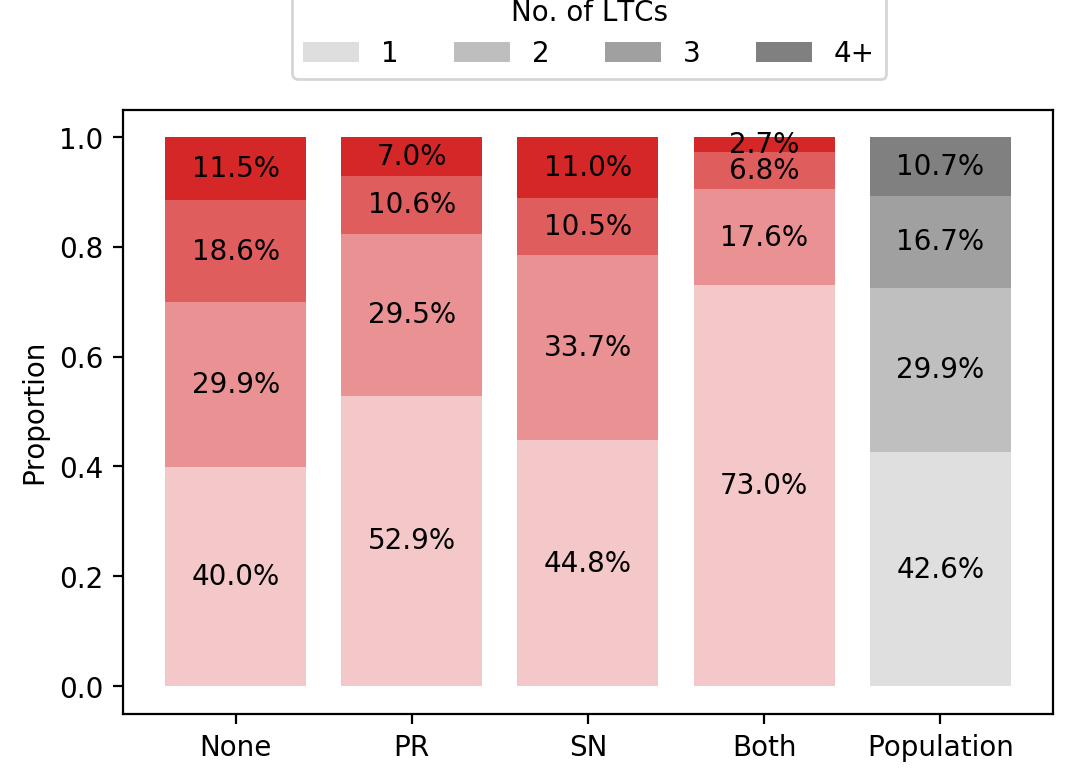

In [14]:
fig, ax = plt.subplots(dpi=200)

handles, labels = [], []
for column in ["none", "pr", "sn", "both", "Population"]:

    bottom = 0
    pos = column
    if column == "Population":
        colour = "gray"
    else:
        colour = "tab:red"
        pos = intervention_labels[column]
        if column in ["pr", "sn"]:
            pos = column.upper()

    for i in range(1, 5):

        alpha = i / 4
        value = ltcs_proportions.loc[i, column]
        if i == 4:
            value = ltcs_proportions.loc[i:, column].sum()
            i = "4+"

        ax.bar(pos, value, bottom=bottom, fc=colour, alpha=alpha)
        ax.text(pos, bottom + .5 * value, f"{value * 100:.1f}%", color="k", va="center", ha="center")
        bottom += value

        if str(i) not in labels:
            labels.append(str(i))
            handles.append(plt.matplotlib.patches.Patch(fc="gray", alpha=alpha))

ax.set(ylabel="Proportion", ylim=(-0.05, 1.05))

leg = fig.legend(handles, labels, ncol=4, bbox_to_anchor=(0.75, 1.01), title="No. of LTCs")

plt.savefig("../img/intervention_ltcs.pdf", bbox_extra_artists=[leg], transparent=True)

In [15]:
cluster_attendances = pd.DataFrame({"Population": [copd["n_copd_admissions_last_year"].mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_attendances[label] = [cluster["n_copd_admissions_last_year"].mean()]

cluster_mean_lengths = pd.DataFrame({"Population": [copd["true_los"].mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_mean_lengths[label] = [cluster["true_los"].mean()]

cluster_min_lengths = pd.DataFrame({"Population": [copd["true_los"].min()]})
for label, cluster in copd.groupby("cluster"):
    cluster_min_lengths[label] = [cluster["true_los"].min()]

cluster_max_lengths = pd.DataFrame({"Population": [copd["true_los"].max()]})
for label, cluster in copd.groupby("cluster"):
    cluster_max_lengths[label] = [cluster["true_los"].max()]

cluster_nicds = pd.DataFrame({"Population": [copd["n_icds"].median()]})
for label, cluster in copd.groupby("cluster"):
    cluster_nicds[label] = [cluster["n_icds"].median()]
    
cluster_ltcs = pd.DataFrame({"Population": [copd.groupby("spell_id")[conditions].max().astype(bool).sum(axis=1).median()]})
for label, cluster in copd.groupby("cluster"):
    cluster_ltcs[label] = [cluster.groupby("spell_id")[conditions].max().astype(bool).sum(axis=1).median()]

cluster_charlsons = pd.DataFrame({"Population": [copd["charlson_gross"].median()]})
for label, cluster in copd.groupby("cluster"):
    cluster_charlsons[label] = [cluster["charlson_gross"].median()]

cluster_costs = pd.DataFrame({"Population": [copd["spell_cost"].mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_costs[label] = [cluster["spell_cost"].mean()]

cluster_ages = pd.DataFrame({"Population": [copd["age"].mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_ages[label] = [cluster["age"].mean()]

nspells = len(copd)
cluster_percentages = pd.DataFrame({"Population": [100.0]})
for label, cluster in copd.groupby("cluster"):
    cluster_percentages[label] = (len(cluster) / nspells) * 100

In [16]:
cluster_characteristics = [
    cluster_percentages,
    cluster_costs,
    cluster_ages,
    cluster_attendances,
    cluster_min_lengths,
    cluster_mean_lengths,
    cluster_max_lengths,
    cluster_ltcs,
    cluster_nicds,
    cluster_charlsons,
]

overall_characteristic = pd.concat(cluster_characteristics, ignore_index=True)
overall_characteristic.index = [
    "Percentage of spells",
    "Mean spell cost, £",
    "Mean age",
    "COPD adm. last year",
    "Minimum LOS",
    "Mean LOS",
    "Maximum LOS",
    "Median no. of LTCs",
    "Median no. of ICDs",
    "Median CCI",
]

overall_characteristic = overall_characteristic[[0, 1, 2, 3, "Population"]]

In [17]:
overall_characteristic

,0,1,2,3,Population
Percentage of spells,9.907007,19.270785,69.385876,1.436332,100.000000
"Mean spell cost, £",8051.231618,2309.634930,1508.408009,17888.432273,2265.398870
Mean age,75.968825,76.675592,70.552731,81.363636,72.205364
COPD adm. last year,2.193309,1.964644,1.881900,2.089744,1.931682
Minimum LOS,12.822917,-0.004861,-0.020833,48.817361,-0.020833
Mean LOS,25.302383,6.463788,4.106279,75.360056,7.683930
Maximum LOS,51.360417,30.859028,16.940972,224.927778,224.927778
Median no. of LTCs,2.000000,3.000000,1.000000,3.000000,1.000000
Median no. of ICDs,9.000000,8.000000,5.000000,11.000000,6.000000
Median CCI,9.000000,20.000000,4.000000,18.000000,4.000000


In [18]:
cluster_intervention_proportions = pd.DataFrame({"Population": copd["intervention"].value_counts(normalize=True)})
for cluster, values in copd.groupby("cluster")["intervention"]:
    proportions = values.value_counts(normalize=True).reindex(["none", "pr", "sn", "both"]).fillna(0)
    cluster_intervention_proportions[cluster] = proportions * 100

new_index = [intervention_labels.get(i) + ", %" for i in cluster_intervention_proportions.index]
cluster_intervention_proportions.index = new_index

In [19]:
cluster_conditions = {}
for cluster, data in copd.groupby("cluster"):
    cluster_conditions[cluster] = data.groupby("spell_id")[conditions].max().astype(bool)

overall_condition = pd.DataFrame()
for label, data in cluster_conditions.items():
    overall_condition[label] = data.mean() * 100

overall_condition["Population"] = pd.concat(cluster_conditions.values()).mean() * 100
overall_condition = overall_condition.sort_values("Population", ascending=False)

condition_labels = {
    "ami": "AMI",
    "cva": "CVA",
    "chf": "CHF",
    "ctd": "CTD",
    "dementia": "Dementia",
    "diabetes": "Diabetes",
    "liver_disease": "Liver disease",
    "peptic_ulcer": "Peptic ulcer",
    "pvd": "PVD",
    "pulmonary_disease": "Pulmonary disease",
    "cancer": "Cancer",
    "diabetic_complications": "Diabetic compl.",
    "paraplegia": "Paraplegia",
    "renal_disease": "Renal disease",
    "metastatic_cancer": "Metastatic cancer",
    "sever_liver_disease": "Severe liver disease",
    "hiv": "HIV",
    "cdiff": "C. diff",
    "mrsa": "MRSA",
    "obese": "Obesity",
    "sepsis": "Sepsis"
}

overall_condition.index = [condition_labels[i] + ", %" for i in overall_condition.index]

In [20]:
summary = pd.concat(
    [overall_characteristic, cluster_intervention_proportions, overall_condition], sort=False
).round(2)

index = pd.MultiIndex.from_tuples(
    [
        *(("Characteristics", i) for i in overall_characteristic.index),
        *(("Intervention prevalence", i) for i in cluster_intervention_proportions.index),
        *(("LTC prevalence", i) for i in overall_condition.index),
    ]
)

columns = pd.MultiIndex.from_tuples(
    [*(("Cluster", i) for i in range(n_clusters)), ("Population", "")]
)

summary.index = index
summary.columns = columns

summary.to_latex("../tex/summary.tex", multicolumn=False, bold_rows=True)

summary

Cluster                    \
                                                       0        1        2   
Characteristics         Percentage of spells        9.91    19.27    69.39   
                        Mean spell cost, £       8051.23  2309.63  1508.41   
                        Mean age                   75.97    76.68    70.55   
                        COPD adm. last year         2.19     1.96     1.88   
                        Minimum LOS                12.82    -0.00    -0.02   
                        Mean LOS                   25.30     6.46     4.11   
                        Maximum LOS                51.36    30.86    16.94   
                        Median no. of LTCs          2.00     3.00     1.00   
                        Median no. of ICDs          9.00     8.00     5.00   
                        Median CCI                  9.00    20.00     4.00   
Intervention prevalence None, %                    80.20    83.42    65.76   
                        Pulmonary rehab., %        15.80    13.43    27.97   
                        Spec. nursing, %            3.81     2.87     4.63   
                        Both, %                     0.19     0.29     1.63   
LTC prevalence          Pulmonary disease, %      100.00   100.00   100.00   
                        Diabetes, %                19.05    28.14    14.84   
                        AMI, %                     13.85    22.93     8.76   
                        CHF, %                     12.45    53.85     0.00   
                        Renal disease, %            7.53    19.54     1.92   
                        Cancer, %                   7.62    12.23     2.93   
                        Dementia, %                 6.88    21.26     0.00   
                        CVA, %                      8.64    13.33     0.70   
                        PVD, %                      4.37     7.69     2.27   
                        CTD, %                      5.11     4.25     3.11   
                        Obesity, %                  2.51     3.01     1.49   
                        Metastatic cancer, %        1.58     4.49     0.00   
                        Paraplegia, %               1.30     3.73     0.24   
                        Diabetic compl., %          0.19     0.86     0.48   
                        Peptic ulcer, %             1.58     0.81     0.23   
                        Sepsis, %                   1.77     0.91     0.15   
                        Liver disease, %            0.28     0.48     0.23   
                        C. diff, %                  0.74     0.10     0.01   
                        Severe liver disease, %     0.19     0.43     0.00   
                        MRSA, %                     0.28     0.05     0.03   
                        HIV, %                      0.00     0.00     0.03   

                                                          Population  
                                                        3             
Characteristics         Percentage of spells         1.44     100.00  
                        Mean spell cost, £       17888.43    2265.40  
                        Mean age                    81.36      72.21  
                        COPD adm. last year          2.09       1.93  
                        Minimum LOS                 48.82      -0.02  
                        Mean LOS                    75.36       7.68  
                        Maximum LOS                224.93     224.93  
                        Median no. of LTCs           3.00       1.00  
                        Median no. of ICDs          11.00       6.00  
                        Median CCI                  18.00       4.00  
Intervention prevalence None, %                     89.74       0.71  
                        Pulmonary rehab., %          8.97       0.24  
                        Spec. nursing, %             1.28       0.04  
                        Both, %                      0.00       0.01  
LTC prevalence          Pu

In [21]:
icd_category_means = pd.DataFrame(copd[codes].mean(), columns=["Population"])
for label, cluster in copd.groupby("cluster"):
    icd_category_means[label] = cluster[codes].mean()

icd_category_means = icd_category_means[[0, 1, 2, 3, "Population"]].sort_values(
    "Population", ascending=False
)

icd_category_means.T

,respiratory,contact_factors,circulatory,endocrine,mental,muscoloskeletal,abnormal_findings,digestive,genitourinary,infectious,...,neoplasms,blood,skin,external_causes,eye,injury,special_use,ear,congenital,perinatal
0,1.757435,1.616171,1.582714,0.686803,0.510223,0.421933,0.690520,0.417286,0.396840,0.319703,...,0.119888,0.125465,0.115242,0.196097,0.074349,0.139405,0.057621,0.024164,0.004647,0.000000
1,1.424749,1.536073,2.269947,0.704252,0.542284,0.321070,0.375538,0.236503,0.376015,0.109890,...,0.205447,0.100334,0.068323,0.059723,0.046345,0.050167,0.016722,0.019589,0.002389,0.000000
2,1.338508,1.104432,0.875663,0.432856,0.474522,0.291269,0.214968,0.179140,0.098461,0.086916,...,0.037951,0.053211,0.037686,0.024018,0.036226,0.019241,0.016720,0.013535,0.002521,0.000133
3,1.711538,1.942308,1.935897,0.858974,0.621795,0.570513,1.108974,0.435897,0.641026,0.410256,...,0.134615,0.192308,0.217949,0.179487,0.108974,0.141026,0.064103,0.121795,0.006410,0.000000
Population,1.401989,1.250345,1.229629,0.516435,0.493233,0.313967,0.305865,0.217475,0.189301,0.119050,...,0.079735,0.071448,0.053862,0.050180,0.042998,0.038855,0.021453,0.017310,0.002762,0.000092
